# Correlation function of DR12G SDSS LOWZ Catalog

First import all the modules such as healpy and astropy needed for analyzing the structure

In [1]:
import healpix_util as hu
import astropy as ap
import numpy as np
from astropy.io import fits
from astropy.table import Table
import astropy.io.ascii as ascii
from astropy.io import fits
from astropy.constants import c
import matplotlib.pyplot as plt
import math as m
from math import pi
#from scipy.constants import c
import scipy.special as sp
from astroML.decorators import pickle_results
from scipy import integrate
import warnings
from sklearn.neighbors import BallTree
import pickle
import multiprocessing as mp
import time
from cython_metric import *
from lcdmmetric import *
from progressbar import *
from tqdm import *
from functools import partial
import pymangle
#from astroML.datasets import fetch_sdss_specgals
#from astroML.correlation import bootstrap_two_point_angular
%matplotlib inline

Read the data file (taken from http://cosmo.nyu.edu/~eak306/SDSS-LRG.html ) converted to ascii with comoving distance etc. in V01 reading from pkl files for faster read

In [2]:
data=ascii.read("./output/dr12glnsrarf.dat")

In [3]:
data

z,ra,dec,s,rar,decr
float64,float64,float64,float64,float64,float64
0.345888,195.21171,-0.505258,0.317743,3.407087,-0.008818
0.33261,225.586971,-0.046532,0.306603,3.937235,-0.000812
0.332531,225.513692,-0.19026,0.306536,3.935956,-0.003321
0.384936,195.151124,0.357886,0.350019,3.40603,0.006246
0.248512,195.095915,-1.063041,0.234083,3.405066,-0.018554
0.30991,195.210161,-1.064036,0.287363,3.40706,-0.018571
0.449055,195.174248,-1.226954,0.401464,3.406433,-0.021414
0.453334,195.310582,-1.140315,0.404829,3.408813,-0.019902
0.192286,195.475965,-1.07152,0.183698,3.411699,-0.018702


In [4]:
data.remove_column('z')
data.remove_column('ra')
data.remove_column('dec')

In [5]:
data

s,rar,decr
float64,float64,float64
0.317743,3.407087,-0.008818
0.306603,3.937235,-0.000812
0.306536,3.935956,-0.003321
0.350019,3.40603,0.006246
0.234083,3.405066,-0.018554
0.287363,3.40706,-0.018571
0.401464,3.406433,-0.021414
0.404829,3.408813,-0.019902
0.183698,3.411699,-0.018702


In [6]:
rs=np.array(data['s'])
rrar=np.array(data['rar'])
rdecr=np.array(data['decr'])

In [7]:
dat=np.array([rs,rrar,rdecr])

In [8]:
dat

array([[  3.17743000e-01,   3.06603000e-01,   3.06536000e-01, ...,
          2.50696000e-01,   1.47683000e-01,   1.98416000e-01],
       [  3.40708700e+00,   3.93723500e+00,   3.93595600e+00, ...,
          3.90935800e+00,   3.91207600e+00,   3.92151700e+00],
       [ -8.81800000e-03,  -8.12000000e-04,  -3.32100000e-03, ...,
          1.10118400e+00,   1.09926800e+00,   1.09672900e+00]])

In [9]:
dat.reshape(3,len(data))

array([[  3.17743000e-01,   3.06603000e-01,   3.06536000e-01, ...,
          2.50696000e-01,   1.47683000e-01,   1.98416000e-01],
       [  3.40708700e+00,   3.93723500e+00,   3.93595600e+00, ...,
          3.90935800e+00,   3.91207600e+00,   3.92151700e+00],
       [ -8.81800000e-03,  -8.12000000e-04,  -3.32100000e-03, ...,
          1.10118400e+00,   1.09926800e+00,   1.09672900e+00]])

In [10]:
dat=dat.transpose()

In [11]:
dat

array([[  3.17743000e-01,   3.40708700e+00,  -8.81800000e-03],
       [  3.06603000e-01,   3.93723500e+00,  -8.12000000e-04],
       [  3.06536000e-01,   3.93595600e+00,  -3.32100000e-03],
       ..., 
       [  2.50696000e-01,   3.90935800e+00,   1.10118400e+00],
       [  1.47683000e-01,   3.91207600e+00,   1.09926800e+00],
       [  1.98416000e-01,   3.92151700e+00,   1.09672900e+00]])

In [12]:
# Saving the objects:
with open('dr12glnLCDM.pkl', 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump(dat, f)

In [2]:
# Getting back the objects:
with open('../pkl/dr12glnLCDM.pkl') as f:  # Python 3: open(..., 'rb')
    dat = pickle.load(f)
dat

array([[  3.17743000e-01,   3.40708700e+00,  -8.81800000e-03],
       [  3.06603000e-01,   3.93723500e+00,  -8.12000000e-04],
       [  3.06536000e-01,   3.93595600e+00,  -3.32100000e-03],
       ..., 
       [  2.50696000e-01,   3.90935800e+00,   1.10118400e+00],
       [  1.47683000e-01,   3.91207600e+00,   1.09926800e+00],
       [  1.98416000e-01,   3.92151700e+00,   1.09672900e+00]])

In [3]:
# Getting back the objects:
with open('../pkl/rdr12glnLCDM.pkl') as f:  # Python 3: open(..., 'rb')
    datR = pickle.load(f)
datR

array([[ 0.317743,  3.144764,  0.799349],
       [ 0.306603,  0.421375,  0.17509 ],
       [ 0.306536,  3.53492 ,  0.343424],
       ..., 
       [ 0.250696,  2.338491,  0.771776],
       [ 0.147683,  2.772683,  0.398022],
       [ 0.198416,  0.440099,  0.079733]])

In [6]:
LCDMmetricsq(dat[0],datR[1])

0.38479457954996177

In [15]:
%%time
BT_D = BallTree(dat,metric='pyfunc',func=LCDMmetricsq) 

with open('BTDdr12glnsLCDM.pkl', 'w') as f:
    pickle.dump(BT_D,f)

CPU times: user 21.3 s, sys: 330 ms, total: 21.7 s
Wall time: 22 s


In [4]:
with open('../pkl/BTDdr12glnsLCDM.pkl') as f:
    BTD = pickle.load(f)
    
BTD

In [7]:
bins=np.arange(0.004,0.084,0.004)
bins

array([ 0.004,  0.008,  0.012,  0.016,  0.02 ,  0.024,  0.028,  0.032,
        0.036,  0.04 ,  0.044,  0.048,  0.052,  0.056,  0.06 ,  0.064,
        0.068,  0.072,  0.076,  0.08 ])

In [8]:
binsq=bins**2
binsq

array([  1.60000000e-05,   6.40000000e-05,   1.44000000e-04,
         2.56000000e-04,   4.00000000e-04,   5.76000000e-04,
         7.84000000e-04,   1.02400000e-03,   1.29600000e-03,
         1.60000000e-03,   1.93600000e-03,   2.30400000e-03,
         2.70400000e-03,   3.13600000e-03,   3.60000000e-03,
         4.09600000e-03,   4.62400000e-03,   5.18400000e-03,
         5.77600000e-03,   6.40000000e-03])

In [9]:
%%time
start_time=time.time()
counts_DD=BTD.two_point_correlation(dat,binsq)
print counts_DD
end_time=time.time()
tottime=end_time-start_time
print "Total run time:"
print tottime

with open('../pkl/BTDdr12glnsDDLCDM.pkl', 'w') as f:
    pickle.dump(counts_DD,f)

with open('../pkl/BTDdr12glnsDDLCDM.pkl') as f:
    counts_DD = pickle.load(f)
    
counts_DD

[   2362899    9375880   24665137   51634060   93466536  153153488
  233552261  337535905  468011932  627112280  817341724 1040611341
 1299129222 1593931889 1926540941 2298624743 2710205801 3162191282
 3655125660 4190717332]
Total run time:
37158.8006971
CPU times: user 10h 8min 11s, sys: 1min 51s, total: 10h 10min 3s
Wall time: 10h 19min 18s


In [10]:
DD=np.diff(counts_DD)
DD

array([  7012981,  15289257,  26968923,  41832476,  59686952,  80398773,
       103983644, 130476027, 159100348, 190229444, 223269617, 258517881,
       294802667, 332609052, 372083802, 411581058, 451985481, 492934378,
       535591672])

In [11]:
%%time
start_time=time.time()
counts_DR=BTD.two_point_correlation(datR,binsq)
print counts_DR
end_time=time.time()
tottime=end_time-start_time
print "Total run time:"
print tottime

with open('../pkl/BTDdr12glnsDRLCDM.pkl', 'w') as f:
    pickle.dump(counts_DR,f)

with open('../pkl/BTDdr12glnsDRLCDM.pkl') as f:
    counts_DR = pickle.load(f)
    
counts_DR

[    504979    3931526   12956346   29997328   57234414   96752341
  150541886  220777339  309385659  418372669  549293838  703563150
  882500548 1087234983 1318858276 1578088357 1865814733 2182502217
 2528443710 2903922644]
Total run time:
17503.951926
CPU times: user 4h 3min 8s, sys: 36.9 s, total: 4h 3min 45s
Wall time: 4h 51min 43s


In [12]:
counts_DR

array([    504979,    3931526,   12956346,   29997328,   57234414,
         96752341,  150541886,  220777339,  309385659,  418372669,
        549293838,  703563150,  882500548, 1087234983, 1318858276,
       1578088357, 1865814733, 2182502217, 2528443710, 2903922644])

In [13]:
DR=np.diff(counts_DR)

In [14]:
DR

array([  3426547,   9024820,  17040982,  27237086,  39517927,  53789545,
        70235453,  88608320, 108987010, 130921169, 154269312, 178937398,
       204734435, 231623293, 259230081, 287726376, 316687484, 345941493,
       375478934])

In [ ]:
plt.plot(bins[1:len(bins)],DR,'bo-')

In [15]:
RR_zero = (RR == 0)
RR[RR_zero] = 1

NameError: name 'RR' is not defined

In [ ]:
corrells=( DD - 2.0 * DR + RR) / RR

In [ ]:
corrells

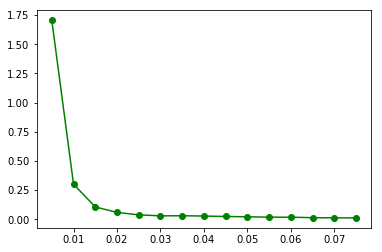

In [60]:
plt.plot(bins[1:len(bins)],corrells,'go-')

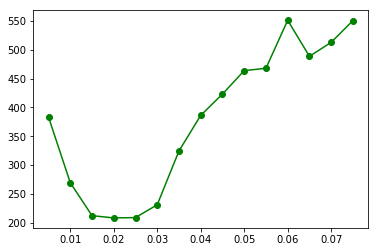

In [61]:
plt.plot(bins[1:len(bins)],bins[1:len(bins)]*bins[1:len(bins)]*corrells*(c*1e-5)**2,'go-')

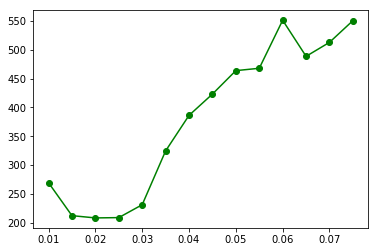

In [62]:
plt.plot(bins[2:len(bins)],bins[2:len(bins)]*bins[2:len(bins)]*corrells[1:len(bins)]*(c*1e-5)**2,'go-')

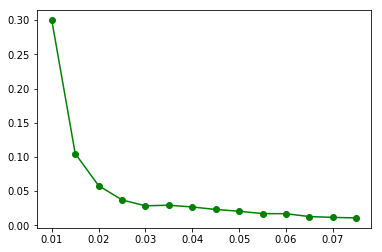

In [64]:
plt.plot(bins[2:len(bins)],corrells[1:len(bins)],'go-')

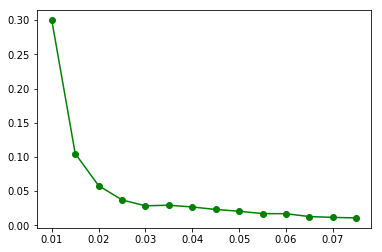

In [69]:
plt.plot(bins[2:len(bins)],corrells[1:len(bins)],'go-')
plt.savefig("correl2xls.pdf")

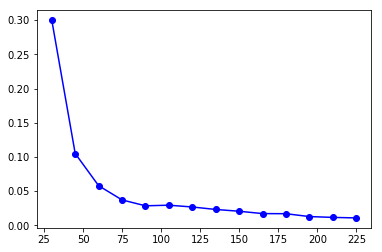

In [70]:
plt.plot(bins[2:len(bins)]*c/1e5,corrells[1:len(bins)],'bo-')
plt.savefig("correl2x1ls.pdf")

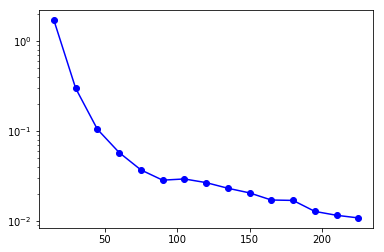

In [72]:
plt.yscale('log')
plt.plot(bins[1:len(bins)]*c/1e5,corrells,'bo-')
plt.savefig("correllsfiglog.pdf")

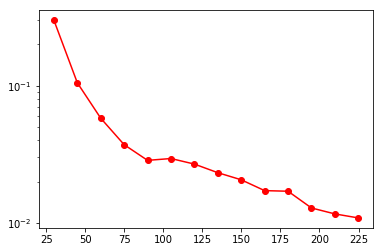

In [71]:
plt.yscale('log')
plt.plot(bins[2:len(bins)]*c/1e5,corrells[1:len(bins)],'ro-')
plt.savefig("correllslog2x.pdf")

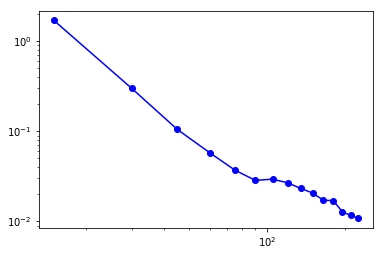

In [73]:
plt.yscale('log')
plt.xscale('log')
plt.plot(bins[1:len(bins)]*c/1e5,corrells,'bo-')
plt.savefig("correllsloglog.pdf")

In [ ]:
from functools import partial

def harvester(text, case):
    X = case[0]
    return text + str(X)


partial_harvester = partial(harvester, case=RAW_DATASET)

partial_qr=partial(BTD.query_radius,count_only=True)

if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=6)
    case_data = RAW_DATASET
    pool.map(partial_harvester, case_data, 1)
    pool.close()
    pool.join()

mapfunc = partial(BTD.query_radius, count_only=True)
map(mapfunc, volume_ids)


In [ ]:
#ascii.write("DR72DDbinned.dat",(bins[1:len(bins)],DDresult))
start_time=time.time()
@pickle_results("DR72DDmp1.pkl")
def ddcal(BTD,dat,bins,Nbins):
    counts_DD=np.zeros(Nbins)
    for i in tqdm(range(Nbins)):
        counts_DD[i]=np.sum(BTD.query_radius(dat, bins[i],count_only=True))
    DD = np.diff(counts_DD)
    print counts_DD
    print DD
    return DD

def mf_wrap(args):
    return ddcal(*args)

pool=mp.Pool(8)

arg=[(BTD,dat,bins,Nbins)]
%timeit DDresult=pool.map(mf_wrap,arg) 
#DDresult = ddcal(BTD,dat,bins,Nbins)
end_time=time.time()
tottime=end_time-start_time
print "Total run time:"
print tottime

In [ ]:
%timeit dat

In [ ]:
DDresult[0]

In [ ]:
DDresult[1]

In [ ]:
plt.plot(bins[1:len(bins)],DDresult[0],'ro')

In [ ]:
def myfun(a,b):
  print a + b
  return a+b

def mf_wrap(args):
  return myfun(*args)

p = mp.Pool(4)

fl = [(a,b) for a in range(3) for b in range(2)]

p.map(mf_wrap, fl)

In [ ]:
counts_DD=np.zeros(Nbins)

for i in range(Nbins):
    counts_DD[i]=np.sum(BTD.query_radius(dat, bins[i],count_only=True))
DD = np.diff(counts_DD)

In [ ]:
print counts_DD
print DD

In [ ]:
plt.plot(bins[1:len(bins)],DD,'ro')

In [ ]:
dataR=fits.open("/Users/rohin/Downloads/random-DR7-Full.fits")

In [ ]:
dataR=dataR[1].data

In [ ]:
len(dataR)

In [ ]:
tdata=np.array(data)

In [ ]:
type(tdata[4])

In [ ]:
tdata.shape

In [ ]:
tdata.shape

In [ ]:
tdata=np.atleast_d(tdata)

In [ ]:
tdata.shape

In [ ]:
tdata.reshape(len(tdata),3)

In [ ]:
tdata=np.asarray(data)
tdata=tdata.transpose()

In [ ]:
tdata

In [ ]:
len(tdata)

In [ ]:
BTD.two_point_correlationpoint_correlationpoint_correlationpoint_correlationtime
stime=time.time()
tpcf=BTD.two_point_correlation(dat,bins)
print time.time()-stime
print tpcf
plt.plot(bins,tpcf)

In [ ]:
stime=time.time()
tpcfd=BTD.two_point_correlation(dat,bins,dualtree=True)
print time.time()-stime
print tpcfd
plt.plot(bins,tpcfd)

In [ ]:
X

In [ ]:
np.random.seed(0)
X = np.random.random((30,3))
r = np.linspace(0, 1, 10)
tree = BallTree(X,metric='pyfunc',func=LCDMmetric)                
s = pickle.dumps(tree)                     
treedump = pickle.loads(s) 
treedump.two_point_correlation(X,r)

In [ ]:
BT_D = BallTree(data)
        BT_R = BallTree(data_R)

        counts_DD = np.zeros(Nbins + 1)
        counts_RR = np.zeros(Nbins + 1)

        for i in range(Nbins + 1):
            counts_DD[i] = np.sum(BT_D.query_radius(data, bins[i],
                                                    count_only=True))
            counts_RR[i] = np.sum(BT_R.query_radius(data_R, bins[i],
                                                    count_only=True))

    DD = np.diff(counts_DD)
    RR = np.diff(counts_RR)

    # check for zero in the denominator
    RR_zero = (RR == 0)
    RR[RR_zero] = 1

    if method == 'standard':
        corr = factor ** 2 * DD / RR - 1
    elif method == 'landy-szalay':
        if sklearn_has_two_point:
            counts_DR = KDT_R.two_point_correlation(data, bins)
        else:
            counts_DR = np.zeros(Nbins + 1)
            for i in range(Nbins + 1):
                counts_DR[i] = np.sum(BT_R.query_radius(data, bins[i],
                                                        count_only=True))
        DR = np.diff(counts_DR)

        corr = (factor ** 2 * DD - 2 * factor * DR + RR) / RR

    corr[RR_zero] = np.nan

    return corr

In [ ]:
dr7fdat=np.array([data['s'][0:300] data['rar'][0:300] data['decr'][0:300]])
dr7fdat

In [ ]:
dr7fdat[2]

In [ ]:
def LCDMmetric(p1,p2):
    costheta=m.sin(dec1)*m.sin(dec2)+m.cos(dec1)*m.cos(dec2)*m.cos(ra1-ra2)
    s1=DC_LCDM(z1)
    s2=DC_LCDM(z2)
    return np.sqrt(s1**2+s2**2-2.0*s1*s2*costheta)

In [ ]:
#fdata=fits.open("/Users/rohin/Downloads/DR7-Full.fits")

In [ ]:
#fdata.writeto("./output/DR7fulltrim.fits")

In [ ]:
fdata=fits.open("./output/DR7fulltrim.fits")

In [ ]:
cols=fdata[1].columns

In [ ]:
cols.del_col('ZTYPE')

In [ ]:
cols.del_col('SECTOR')
cols.del_col('FGOTMAIN')
cols.del_col('QUALITY')
cols.del_col('ISBAD')
cols.del_col('M')
cols.del_col('MMAX')
cols.del_col('ILSS')
cols.del_col('ICOMB')
cols.del_col('VAGC_SELECT')
cols.del_col('LSS_INDEX')
cols.del_col('FIBERWEIGHT')
cols.del_col('PRIMTARGET')
cols.del_col('MG')
cols.del_col('SECTOR_COMPLETENESS')
cols.del_col('COMOV_DENSITY')
cols.del_col('RADIAL_WEIGHT')

In [ ]:
fdata[1].columns

In [ ]:
fdata.writeto("./output/DR7fullzradec.fits")

In [ ]:
fdat=fits.open("./output/DR7fullzradec.fits")

In [ ]:
fdat[1].columns

In [ ]:
fdat[1].data['Z']

In [ ]:
fdat[1].data['RA']

In [ ]:
comovlcdm=DC_LCDM(fdat[1].data['Z'])

In [ ]:
fdat[1].data['Z']

In [ ]:
comovlcdm

In [ ]:
comovlcdm.dtype

In [ ]:
#cols=fdat[1].columns

In [ ]:
nc=fits.Column(name='COMOV',format='D',array=comovlcdm)

In [ ]:
nc1=fits.Column(name='COMOV',format='D')

In [ ]:
fdata[1].data['Z']

In [ ]:
fdata[1].data['RA']

In [ ]:
nc

In [ ]:
nc.dtype

In [ ]:
#cols.add_col(nc)

In [ ]:
fdat[1].columns

In [ ]:
fdat[1].columns.info()

In [ ]:
fdat[1].columns.add_col(nc1)

In [ ]:
fdat[1].data['COMOV']=comovlcdm

In [ ]:
comovlcdm

In [ ]:
fdat[1].data['Z']

In [ ]:
fdat[1].data['COMOV']

In [ ]:
fdat[1].data['RA']

In [ ]:
fdat[1].data['RA']=fdat[1].data['RA']*pi/180.0

In [ ]:
comovlcdm=DC_LCDM(fdat[1].data['Z'])
comovlcdm

Random catalog created based on the survey limitations also taken from http://cosmo.nyu.edu/~eak306/SDSS-LRG.html

In [ ]:
dataR=fits.open("/Users/rohin/Downloads/random-DR7-Full.fits")

In [ ]:
dataR

In [ ]:
dataR=dataR[1].data

In [ ]:
len(dataR)

In [ ]:
NSIDE=512
dr72hpix=hu.HealPix("ring",NSIDE)

In [ ]:
pixdata = open("./output/pixdatadr72VAGCfullrand.dat",'w')
pixdata.write("z\t pix \n")

for i in range(0,len(data)-1):
    pixdata.write("%f\t" %data['z'][i])
    pixdata.write("%d\n" %dr72hpix.eq2pix(dataR['ra'][i],dataR['dec'][i]))
pixdata.close()

In [ ]:
pixdata = ascii.read("./output/pixdatadr72VAGCfullrand.dat")
hpixdata=np.array(np.zeros(hu.nside2npix(NSIDE)))
for j in range(len(pixdata)):
    hpixdata[pixdata[j]['pix']]+=1

In [ ]:
hpixdata

In [ ]:
hu.mollview(hpixdata,rot=180)

In [ ]:
hu.orthview(hpixdata)

In [ ]:
"""
Tools for computing two-point correlation functions.
"""

#from .utils import check_random_state
# From scikit-learn utilities:
def check_random_state(seed):
    """Turn seed into a np.random.RandomState instance

    If seed is None, return the RandomState singleton used by np.random.
    If seed is an int, return a new RandomState instance seeded with seed.
    If seed is already a RandomState instance, return it.
    Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, (int, np.integer)):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError('%r cannot be used to seed a numpy.random.RandomState'
                     ' instance' % seed)

# Check if scikit-learn's two-point functionality is available.
# This was added in scikit-learn version 0.14
try:
    from sklearn.neighbors import KDTree
    sklearn_has_two_point = True
except ImportError:
    import warnings
    sklearn_has_two_point = False


def uniform_sphere(RAlim, DEClim, size=1):
    """Draw a uniform sample on a sphere

    Parameters
    ----------
    RAlim : tuple
        select Right Ascension between RAlim[0] and RAlim[1]
        units are degrees
    DEClim : tuple
        select Declination between DEClim[0] and DEClim[1]
    size : int (optional)
        the size of the random arrays to return (default = 1)

    Returns
    -------
    RA, DEC : ndarray
        the random sample on the sphere within the given limits.
        arrays have shape equal to size.
    """
    zlim = np.sin(np.pi * np.asarray(DEClim) / 180.)

    z = zlim[0] + (zlim[1] - zlim[0]) * np.random.random(size)
    DEC = (180. / np.pi) * np.arcsin(z)
    RA = RAlim[0] + (RAlim[1] - RAlim[0]) * np.random.random(size)

    return RA, DEC


def ra_dec_to_xyz(ra, dec):
    """Convert ra & dec to Euclidean points

    Parameters
    ----------
    ra, dec : ndarrays

    Returns
    x, y, z : ndarrays
    """
    sin_ra = np.sin(ra * np.pi / 180.)
    cos_ra = np.cos(ra * np.pi / 180.)

    sin_dec = np.sin(np.pi / 2. - dec * np.pi / 180.)
    cos_dec = np.cos(np.pi / 2. - dec * np.pi / 180.)

    return (cos_ra * sin_dec,
            sin_ra * sin_dec,
            cos_dec)


def angular_dist_to_euclidean_dist(D, r=1):
    """convert angular distances to euclidean distances"""
    return 2 * r * np.sin(0.5 * D * np.pi / 180.)


def two_point(data, bins, method='standard',
              data_R=None, random_state=None):
    """Two-point correlation function

    Parameters
    ----------
    data : array_like
        input data, shape = [n_samples, n_features]
    bins : array_like
        bins within which to compute the 2-point correlation.
        shape = Nbins + 1
    method : string
        "standard" or "landy-szalay".
    data_R : array_like (optional)
        if specified, use this as the random comparison sample
    random_state : integer, np.random.RandomState, or None
        specify the random state to use for generating background

    Returns
    -------
    corr : ndarray
        the estimate of the correlation function within each bin
        shape = Nbins
    """
    data = np.asarray(data)
    bins = np.asarray(bins)
    rng = check_random_state(random_state)

    if method not in ['standard', 'landy-szalay']:
        raise ValueError("method must be 'standard' or 'landy-szalay'")

    if bins.ndim != 1:
        raise ValueError("bins must be a 1D array")

    if data.ndim == 1:
        data = data[:, np.newaxis]
    elif data.ndim != 2:
        raise ValueError("data should be 1D or 2D")

    n_samples, n_features = data.shape
    Nbins = len(bins) - 1

    # shuffle all but one axis to get background distribution
    if data_R is None:
        data_R = data.copy()
        for i in range(n_features - 1):
            rng.shuffle(data_R[:, i])
    else:
        data_R = np.asarray(data_R)
        if (data_R.ndim != 2) or (data_R.shape[-1] != n_features):
            raise ValueError('data_R must have same n_features as data')

    factor = len(data_R) * 1. / len(data)

    if sklearn_has_two_point:
        # Fast two-point correlation functions added in scikit-learn v. 0.14
        KDT_D = KDTree(data)
        KDT_R = KDTree(data_R)

        counts_DD = KDT_D.two_point_correlation(data, bins)
        counts_RR = KDT_R.two_point_correlation(data_R, bins)

    else:
        warnings.warn("Version 0.3 of astroML will require scikit-learn "
                      "version 0.14 or higher for correlation function "
                      "calculations. Upgrade to sklearn 0.14+ now for much "
                      "faster correlation function calculations.")

        BT_D = BallTree(data)
        BT_R = BallTree(data_R)

        counts_DD = np.zeros(Nbins + 1)
        counts_RR = np.zeros(Nbins + 1)

        for i in range(Nbins + 1):
            counts_DD[i] = np.sum(BT_D.query_radius(data, bins[i],
                                                    count_only=True))
            counts_RR[i] = np.sum(BT_R.query_radius(data_R, bins[i],
                                                    count_only=True))

    DD = np.diff(counts_DD)
    RR = np.diff(counts_RR)

    # check for zero in the denominator
    RR_zero = (RR == 0)
    RR[RR_zero] = 1

    if method == 'standard':
        corr = factor ** 2 * DD / RR - 1
    elif method == 'landy-szalay':
        if sklearn_has_two_point:
            counts_DR = KDT_R.two_point_correlation(data, bins)
        else:
            counts_DR = np.zeros(Nbins + 1)
            for i in range(Nbins + 1):
                counts_DR[i] = np.sum(BT_R.query_radius(data, bins[i],
                                                        count_only=True))
        DR = np.diff(counts_DR)

        corr = (factor ** 2 * DD - 2 * factor * DR + RR) / RR

    corr[RR_zero] = np.nan

    return corr


def bootstrap_two_point(data, bins, Nbootstrap=10,
                        method='standard', return_bootstraps=False,
                        random_state=None):
    """Bootstrapped two-point correlation function

    Parameters
    ----------
    data : array_like
        input data, shape = [n_samples, n_features]
    bins : array_like
        bins within which to compute the 2-point correlation.
        shape = Nbins + 1
    Nbootstrap : integer
        number of bootstrap resamples to perform (default = 10)
    method : string
        "standard" or "landy-szalay".
    return_bootstraps: bool
        if True, return full bootstrapped samples
    random_state : integer, np.random.RandomState, or None
        specify the random state to use for generating background

    Returns
    -------
    corr, corr_err : ndarrays
        the estimate of the correlation function and the bootstrap
        error within each bin. shape = Nbins
    """
    data = np.asarray(data)
    bins = np.asarray(bins)
    rng = check_random_state(random_state)

    if method not in ['standard', 'landy-szalay']:
        raise ValueError("method must be 'standard' or 'landy-szalay'")

    if bins.ndim != 1:
        raise ValueError("bins must be a 1D array")

    if data.ndim == 1:
        data = data[:, np.newaxis]
    elif data.ndim != 2:
        raise ValueError("data should be 1D or 2D")

    if Nbootstrap < 2:
        raise ValueError("Nbootstrap must be greater than 1")

    n_samples, n_features = data.shape

    # get the baseline estimate
    corr = two_point(data, bins, method=method, random_state=rng)

    bootstraps = np.zeros((Nbootstrap, len(corr)))

    for i in range(Nbootstrap):
        indices = rng.randint(0, n_samples, n_samples)
        bootstraps[i] = two_point(data[indices, :], bins, method=method,
                                  random_state=rng)

    # use masked std dev in case of NaNs
    corr_err = np.asarray(np.ma.masked_invalid(bootstraps).std(0, ddof=1))

    if return_bootstraps:
        return corr, corr_err, bootstraps
    else:
        return corr, corr_err


def two_point_angular(ra, dec, bins, method='standard', random_state=None):
    """Angular two-point correlation function

    A separate function is needed because angular distances are not
    euclidean, and random sampling needs to take into account the
    spherical volume element.

    Parameters
    ----------
    ra : array_like
        input right ascention, shape = (n_samples,)
    dec : array_like
        input declination
    bins : array_like
        bins within which to compute the 2-point correlation.
        shape = Nbins + 1
    method : string
        "standard" or "landy-szalay".
    random_state : integer, np.random.RandomState, or None
        specify the random state to use for generating background

    Returns
    -------
    corr : ndarray
        the estimate of the correlation function within each bin
        shape = Nbins
    """
    ra = np.asarray(ra)
    dec = np.asarray(dec)
    rng = check_random_state(random_state)

    if method not in ['standard', 'landy-szalay']:
        raise ValueError("method must be 'standard' or 'landy-szalay'")

    if bins.ndim != 1:
        raise ValueError("bins must be a 1D array")

    if (ra.ndim != 1) or (dec.ndim != 1) or (ra.shape != dec.shape):
        raise ValueError('ra and dec must be 1-dimensional '
                         'arrays of the same length')

    n_features = len(ra)
    Nbins = len(bins) - 1

    # draw a random sample with N points
    ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                                 (min(dec), max(dec)),
                                 2 * len(ra))

    data = np.asarray(ra_dec_to_xyz(ra, dec), order='F').T
    data_R = np.asarray(ra_dec_to_xyz(ra_R, dec_R), order='F').T

    # convert spherical bins to cartesian bins
    bins_transform = angular_dist_to_euclidean_dist(bins)

    return two_point(data, bins_transform, method=method,
                     data_R=data_R, random_state=rng)


def bootstrap_two_point_angular(ra, dec, bins, method='standard',
                                Nbootstraps=10, random_state=None):
    # type: (object, object, object, object, object, object) -> object
    """Angular two-point correlation function

    A separate function is needed because angular distances are not
    euclidean, and random sampling needs to take into account the
    spherical volume element.

    Parameters
    ----------
    ra : array_like
        input right ascention, shape = (n_samples,)
    dec : array_like
        input declination
    bins : array_like
        bins within which to compute the 2-point correlation.
        shape = Nbins + 1
    method : string
        "standard" or "landy-szalay".
    Nbootstraps : int
        number of bootstrap resamples
    random_state : integer, np.random.RandomState, or None
        specify the random state to use for generating background

    Returns
    -------
    corr : ndarray
        the estimate of the correlation function within each bin
        shape = Nbins
    dcorr : ndarray
        error estimate on dcorr (sample standard deviation of
        bootstrap resamples)
    bootstraps : ndarray
        The full sample of bootstraps used to compute corr and dcorr
    """
    ra = np.asarray(ra)
    dec = np.asarray(dec)
    rng = check_random_state(random_state)

    if method not in ['standard', 'landy-szalay']:
        raise ValueError("method must be 'standard' or 'landy-szalay'")

    if bins.ndim != 1:
        raise ValueError("bins must be a 1D array")

    if (ra.ndim != 1) or (dec.ndim != 1) or (ra.shape != dec.shape):
        raise ValueError('ra and dec must be 1-dimensional '
                         'arrays of the same length')

    n_features = len(ra)
    Nbins = len(bins) - 1
    data = np.asarray(ra_dec_to_xyz(ra, dec), order='F').T

    # convert spherical bins to cartesian bins
    bins_transform = angular_dist_to_euclidean_dist(bins)

    bootstraps = []

    for i in range(Nbootstraps):
        # draw a random sample with N points
        ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                                     (min(dec), max(dec)),
                                     2 * len(ra))

        data_R = np.asarray(ra_dec_to_xyz(ra_R, dec_R), order='F').T

        if i > 0:
            # random sample of the data
            ind = np.random.randint(0, data.shape[0], data.shape[0])
            data_b = data[ind]
        else:
            data_b = data

        bootstraps.append(two_point(data_b, bins_transform, method=method,
                                    data_R=data_R, random_state=rng))

    bootstraps = np.asarray(bootstraps)
    corr = np.mean(bootstraps, 0)
    corr_err = np.std(bootstraps, 0, ddof=1)

    return corr, corr_err, bootstraps

In [ ]:
sklearn_has_two_point

In [ ]:
help(KDTree)

In [ ]:
dataxyz=ra_dec_to_xyz(data['ra'],data['dec'])

In [ ]:
dataxyz=np.asarray(dataxyz)

In [ ]:
dataxyz=dataxyz.transpose()

In [ ]:
dataxyz

In [ ]:
dataxyzR=ra_dec_to_xyz(dataR['ra'],dataR['dec'])

In [ ]:
dataxyzR=np.asarray(dataxyzR)

In [ ]:
dataxyzR=dataxyzR.transpose()

In [ ]:
dataxyzR

In [ ]:
bins=np.arange(0.0,1.05,0.05)

In [ ]:
bins

In [ ]:
#@pickle_results("tpcf_std.pkl")
tpcf=two_point(dataxyz,bins,method='standard',data_R=dataxyzR, random_state=None)

In [ ]:
tpcf 

In [ ]:
plt.plot(bins[1:],tpcf,'ro')

In [ ]:
tpcfam=two_point(dataxyz,bins,method='standard',data_R=None, random_state=None)

In [ ]:
tpcfam

In [ ]:
plt.plot(bins[1:],tpcfam,'bo')

In [ ]:
bins2=np.arange(0.2,0.6,0.02)

In [ ]:
tpcfamb2=two_point(dataxyz,bins2,method='standard',data_R=None, random_state=None)

In [ ]:
plt.plot(bins2[1:],tpcfamb2,'go')

The above doesn't show any BAO feature... It used inbuilt astroML method to generate random catalog... by shuffling the original data's content... That way all of the random points fall in the same survey area and will adhere to all the filtering criteria... the factor or ratio of data pts vs. random pts will be 1... instead of large no. in case if we take existing random catalog or create one

In [ ]:
rng = check_random_state(None)

n_samples, n_features = dataxyz.shape
Nbins = len(bins) - 1

# shuffle all but one axis to get background distribution
data_Rxyz = dataxyz.copy()
print data_Rxyz
for i in range(n_features - 1):
    rng.shuffle(data_Rxyz[:, i])
print data_Rxyz

Lets see how it looks with a healpix map

In [ ]:
NSIDE=512
dr72hpix=hu.HealPix("ring",NSIDE)

In [ ]:
import math as m

def cart2sph(x,y,z):
    XsqPlusYsq = x**2 + y**2
    r = m.sqrt(XsqPlusYsq + z**2)               # r
    elev = m.atan2(z,m.sqrt(XsqPlusYsq))     # theta
    az = m.atan2(y,x)                           # phi
    return r, elev, az

def cart2sphA(pts):
    return np.array([cart2sph(x,y,z) for x,y,z in pts])

def appendSpherical(xyz):
    np.hstack((xyz, cart2sphA(xyz)))

In [ ]:
ang=cart2sphA(data_Rxyz)

In [ ]:
ang

In [ ]:
ang.shape

In [ ]:
#ang.resize((105831, 2))
np.squeeze(ang, axis=None)

In [ ]:
help(ang.squeeze)

In [ ]:
ang2=ang[:,1:]

In [ ]:
ang2

In [ ]:
ang2.shape

In [ ]:
ang2[2,0]

In [ ]:
pixdata = open("./output/pixdatadr72VAGCfullrandam.dat",'w')
pixdata.write("pix \n")
for i in range(0,len(ang2)-1):
    #pixdata.write("%f\t" %data['z'][i])
    pixdata.write("%d\n" %dr72hpix.ang2pix(ang2[i,0],ang2[i,1]))
pixdata.close()

In [ ]:
pixdata = ascii.read("./output/pixdatadr72VAGCfullrandam.dat")
hpixdata=np.array(np.zeros(hu.nside2npix(NSIDE)))
for j in range(len(pixdata)):
    hpixdata[pixdata[j]['pix']]+=1

In [ ]:
hpixdata

In [ ]:
hu.mollview(hpixdata,rot=180)

In [ ]:
hu.orthview(hpixdata)

This method doesnt seem to produce right random catalogs...doing it with ra and dec as follows

In [ ]:
data

In [ ]:
data['z'],data['ra'],data['dec']

In [ ]:
datzradec=np.array([data['z'], data['ra'], data['dec']])

In [ ]:
datzradec

In [ ]:
rng = check_random_state(None)

n_features, n_samples  = datzradec.shape

# shuffle all but one axis to get background distribution
data_Rzradec = datzradec.copy()
print data_Rzradec
for i in range(1,n_features):
    rng.shuffle(data_Rzradec[:, i])
print data_Rzradec

In [ ]:
min(data_Rzradec[:, 1])

In [ ]:
max(data_Rzradec[:, 1])

In [ ]:
min(data_Rzradec[:, 2])

In [ ]:
max(data_Rzradec[:, 2])

In [ ]:
min(datzradec[:, 1])

In [ ]:
max(datzradec[:, 1])

In [ ]:
min(datzradec[:, 2])

In [ ]:
max(datzradec[:, 2])

In [ ]:
range(1,3)

In [ ]:
help(rng.shuffle)

In [ ]:
n_samples

In [ ]:
n_features

In [ ]:
data_Rzradec

In [ ]:
data_Rzradec[0][2]

In [ ]:
len(data_Rzradec[0][:])

In [ ]:
data_Rzradec[0][:]

In [ ]:
pixdata = open("./output/pixdatadr72VAGCfullrandamrd.dat",'w')
pixdata.write("z\t pix \n")
for i in range(0,len(data_Rzradec[0][:])-1):
    pixdata.write("%f\t" %data_Rzradec[0][i])
    pixdata.write("%d\n" %dr72hpix.eq2pix(data_Rzradec[1][i],data_Rzradec[2][i]))
pixdata.close()

In [ ]:
pixdata = ascii.read("./output/pixdatadr72VAGCfullrandamrd.dat")
hpixdata=np.array(np.zeros(hu.nside2npix(NSIDE)))
for j in range(len(pixdata)):
    hpixdata[pixdata[j]['pix']]+=1

In [ ]:
hpixdata

In [ ]:
hu.mollview(hpixdata,rot=180)

In [ ]:
hu.orthview(hpixdata)

In [ ]:
dataxyz

In [ ]:
dataxyzR1=ra_dec_to_xyz(data_Rzradec[1][:],data_Rzradec[2][:])

In [ ]:
data_Rzradec[1][:]

In [ ]:
dataxyzR1

In [ ]:
dataxyzR1=np.asarray(dataxyzR1)

In [ ]:
dataxyzR1=dataxyzR1.transpose()

In [ ]:
dataxyzR1

In [ ]:
bins=np.arange(0.025,1.025,0.025)

In [ ]:
bins

In [ ]:
#@pickle_results("tpcf_std.pkl")
tpcf=two_point(dataxyz,bins,method='standard',data_R=dataxyzR1, random_state=None)

In [ ]:
tpcf 

In [ ]:
plt.plot(bins[1:],tpcf,'ro')

In [ ]:
bins=np.arange(0.0,1.05,0.05)

In [ ]:
#@pickle_results("tpcf_std.pkl")
tpcf=two_point(dataxyz,bins,method='standard',data_R=dataxyzR1, random_state=None)

In [ ]:
tpcf 

In [ ]:
plt.plot(bins[1:],tpcf,'ro')

In [ ]:
btpcf=bootstrap_two_point(dataxyz, bins, Nbootstrap=10,
                        method='standard', return_bootstraps=False,
                        random_state=None)

In [ ]:
btpcf

In [ ]:
plt.errorbar(bins[1:],btpcf[0],yerr=btpcf[1],fmt='ro-')

In [ ]:
help(plt.errorbar)

In [ ]:
@pickle_results("tpcf_ls.pkl")
tpcfls=two_point(dataxyz,bins,method='landy-szalay',
              data_R=dataxyzR, random_state=None)

In [ ]:
#------------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.
@pickle_results("correlation_functionsdr72.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1. / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

(bins, r_corr, r_corr_err, r_bootstraps) = compute_results()

bin_centers = 0.5 * (bins[1:] + bins[:-1])

In [ ]:
bins

In [ ]:
r_corr

In [ ]:
r_corr_err

In [ ]:
r_bootstraps

In [ ]:
#------------------------------------------------------------
# Plot the results

label = '$0.15<z<0.25$\n$N=33813$' 

fig = plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
plt.errorbar(bin_centers, r_corr, r_corr_err,fmt='.k', ecolor='gray', lw=1)
fig.text(0.8, 0.8, label, ha='right', va='top')
plt.xlabel(r'$\theta\ (deg)$')
plt.ylabel(r'$w(\theta)$')
plt.show()

plt.show()
fig.savefig("wth_dr72015025.pdf")

In [ ]:
data=ascii.read('./input/sdssdr72_sorted_z.dat')

In [ ]:
data

In [ ]:
#m_max = 19

# redshift and magnitude cuts
data = data[data['z'] > 0.05]
data = data[data['z'] < 0.15]
#data = data[data['petroMag_r'] < m_max]

# RA/DEC cuts
RAmin, RAmax = 140, 220
DECmin, DECmax = 5, 45
data = data[data['ra'] < RAmax]
data = data[data['ra'] > RAmin]
data = data[data['dec'] < DECmax]
data = data[data['dec'] > DECmin]

#ur = data['modelMag_u'] - data['modelMag_r']
#flag_red = (ur > 2.22)
#flag_blue = ~flag_red

#datag 

print "data size:"
print "  total gals: ", len(data)
#print "  blue gals:", len(data_blue)

In [ ]:
NSIDE=512
dr72hpix=hu.HealPix("ring",NSIDE)

In [ ]:
pixdata = open("./output/pixdatadr72005015.dat",'w')
pixdata.write("z\t pix \n")

for i in range(0,len(data)-1):
    pixdata.write("%f\t" %data['z'][i])
    pixdata.write("%d\n" %dr72hpix.eq2pix(data['ra'][i],data['dec'][i]))
pixdata.close()

In [ ]:
pixdata = ascii.read("./output/pixdatadr72005015.dat")
hpixdata=np.array(np.zeros(hu.nside2npix(NSIDE)))
for j in range(len(pixdata)):
    hpixdata[pixdata[j]['pix']]+=1

In [ ]:
hpixdata

In [ ]:
hu.mollview(hpixdata,rot=180)

In [ ]:
hu.orthview(hpixdata)

In [ ]:
#------------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.
@pickle_results("correlation_functionsdr720515.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1. / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

(bins, r_corr, r_corr_err, r_bootstraps) = compute_results()

bin_centers = 0.5 * (bins[1:] + bins[:-1])

In [ ]:
bins

In [ ]:
r_corr

In [ ]:
r_corr_err

In [ ]:
r_bootstraps

In [ ]:
#------------------------------------------------------------
# Plot the results
label = '$0.05<z<0.15$\n$N=138051$'

fig = plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
plt.errorbar(bin_centers, r_corr, r_corr_err,fmt='.k', ecolor='gray', lw=1)
fig.text(0.8, 0.8, label, ha='right', va='top')
plt.xlabel(r'$\theta\ (deg)$')
plt.ylabel(r'$w(\theta)$')
plt.show()
fig.savefig("wth_dr72005015.pdf")

In [ ]:
plt.errorbar(bins[0:len(bins)-1],r_corr,r_corr_err)

In [ ]:
data=ascii.read('./input/sdssdr72_sorted_z.dat')

In [ ]:
data

In [ ]:
data['z']

In [ ]:
#m_max = 19

# redshift and magnitude cuts
data = data[data['z'] > 0.05]
data = data[data['z'] <= 0.10]
#data = data[data['petroMag_r'] < m_max]

# RA/DEC cuts
RAmin, RAmax = 140, 220
DECmin, DECmax = 5, 45
data = data[data['ra'] < RAmax]
data = data[data['ra'] > RAmin]
data = data[data['dec'] < DECmax]
data = data[data['dec'] > DECmin]

#ur = data['modelMag_u'] - data['modelMag_r']
#flag_red = (ur > 2.22)
#flag_blue = ~flag_red

#datag 

print "data size:"
print "  total gals: ", len(data)
#print "  blue gals:", len(data_blue)

In [ ]:
NSIDE=512
dr72hpix=hu.HealPix("ring",NSIDE)

In [ ]:
pixdata = open("./output/pixdatadr7200501.dat",'w')
pixdata.write("z\t pix \n")

for i in range(0,len(data)-1):
    pixdata.write("%f\t" %data['z'][i])
    pixdata.write("%d\n" %dr72hpix.eq2pix(data['ra'][i],data['dec'][i]))
pixdata.close()

In [ ]:
pixdata = ascii.read("./output/pixdatadr7200501.dat")
hpixdata=np.array(np.zeros(hu.nside2npix(NSIDE)))
for j in range(len(pixdata)):
    hpixdata[pixdata[j]['pix']]+=1

In [ ]:
hpixdata

In [ ]:
hu.mollview(hpixdata,rot=180)

In [ ]:
hu.orthview(hpixdata)

In [ ]:
#------------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.
@pickle_results("correlation_functionsdr720501.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1. / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

(bins, r_corr, r_corr_err, r_bootstraps) = compute_results()

bin_centers = 0.5 * (bins[1:] + bins[:-1])

In [ ]:
bins

In [ ]:
r_corr

In [ ]:
r_corr_err

In [ ]:
r_bootstraps

In [ ]:
#------------------------------------------------------------
# Plot the results

label = '$0.05<z<0.10$\n$N=78939$'

fig = plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
plt.errorbar(bin_centers, r_corr, r_corr_err,fmt='.k', ecolor='gray', lw=1)
fig.text(0.8, 0.8, label, ha='right', va='top')
plt.xlabel(r'$\theta\ (deg)$')
plt.ylabel(r'$w(\theta)$')
plt.show()
fig.savefig("wth_dr720501.pdf")

In [ ]:
plt.errorbar(bins[0:len(bins)-1],r_corr,r_corr_err)

In [ ]:
data=ascii.read('./input/sdssdr72_sorted_z.dat')

In [ ]:
data

In [ ]:
data['z']

In [ ]:
#m_max = 19

# redshift and magnitude cuts
data = data[data['z'] > 0.10]
data = data[data['z'] <= 0.15]
#data = data[data['petroMag_r'] < m_max]

# RA/DEC cuts
RAmin, RAmax = 140, 220
DECmin, DECmax = 5, 45
data = data[data['ra'] < RAmax]
data = data[data['ra'] > RAmin]
data = data[data['dec'] < DECmax]
data = data[data['dec'] > DECmin]

#ur = data['modelMag_u'] - data['modelMag_r']
#flag_red = (ur > 2.22)
#flag_blue = ~flag_red

#datag 

print "data size:"
print "  total gals: ", len(data)
#print "  blue gals:", len(data_blue)

In [ ]:
NSIDE=512
dr72hpix=hu.HealPix("ring",NSIDE)

In [ ]:
pixdata = open("./output/pixdatadr72001015.dat",'w')
pixdata.write("z\t pix \n")

for i in range(0,len(data)-1):
    pixdata.write("%f\t" %data['z'][i])
    pixdata.write("%d\n" %dr72hpix.eq2pix(data['ra'][i],data['dec'][i]))
pixdata.close()

In [ ]:
pixdata = ascii.read("./output/pixdatadr72001015.dat")
hpixdata=np.array(np.zeros(hu.nside2npix(NSIDE)))
for j in range(len(pixdata)):
    hpixdata[pixdata[j]['pix']]+=1

In [ ]:
hpixdata

In [ ]:
hu.mollview(hpixdata,rot=180)

In [ ]:
hu.orthview(hpixdata)

In [ ]:
#------------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.
@pickle_results("correlation_functionsdr72001015.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1. / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

(bins, r_corr, r_corr_err, r_bootstraps) = compute_results()

bin_centers = 0.5 * (bins[1:] + bins[:-1])

In [ ]:
bins

In [ ]:
r_corr

In [ ]:
r_corr_err

In [ ]:
r_bootstraps

In [ ]:
#------------------------------------------------------------
# Plot the results

label = '$0.10<z<0.15$\n$N=59112$'
fig = plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
plt.errorbar(bin_centers, r_corr, r_corr_err,fmt='.k', ecolor='gray', lw=1)
fig.text(0.8, 0.8, label, ha='right', va='top')
plt.xlabel(r'$\theta\ (deg)$')
plt.ylabel(r'$w(\theta)$')
plt.show()
fig.savefig("wth_dr7201015.pdf")

In [ ]:
plt.errorbar(bins[0:len(bins)-1],r_corr,r_corr_err)

In [ ]:
hu.mollview(hpixdatab,rot=180)

In [ ]:
hu.orthview(hpixdatab)

In [ ]:
help(hu.mollview)

In [ ]:

from astroML.datasets import fetch_sdss_specgals
from astroML.correlation import bootstrap_two_point_angular

In [ ]:
help(bootstrap_two_point_angular)

In [ ]:
help(astroML.correlation)

In [ ]:
import astroML.correlation

In [ ]:
import sklearn.neighbors

In [ ]:
help(sklearn.neighbors)

Sorted and reduced column set data can now be 'read' to reduce RAM requirements of the table reading. 

In [ ]:
sdssdr72=ascii.read('./input/dssdr72_sorted_z.dat')

Create a healpix map with NSIDE=64 (no. of pixels = 49152 as $NPIX=12\times NSIDE^2$) because the no. of galaxies in the survey are less. For higher resolution (later for dr12) we will consider NSIDE=512 or even 1024. For now, we will create a 64 NSIDE map.

In [ ]:
NSIDE=64
dt72hpix=hu.HealPix("ring",NSIDE)

We have data of galaxies with redshifts between 0 and 0.5 ($0<z<0.5$). To look at a time slice/at a certain epoch we need to choose the list of galaxies within a redshift window. As, measurement of redshift has $\pm 0.05$ error. We can bin all the data into redshifts with range limited to 0.05 variation each. So, we have 10 databins with almost identical redshifts. We save each databin in a different file. 

In [ ]:
j=0
for i in range(1,17):
    pixdata = open("/home/rohin/Desktop/healpix/binned1/pixdata%d_%d.dat"%(NSIDE,i),'w')
    pixdata.write("ra\t dec\t z\t pix \n")
    #for j in range(len(sdssdr72)):
    try:
        while sdssdr72[j]['z']<0.03*i:
            pixdata.write("%f\t" %sdssdr72[j]['ra'])
            pixdata.write("%f\t" %sdssdr72[j]['dec'])
            pixdata.write("%f\t" %sdssdr72[j]['z'])
            pixdata.write("%d\n" %dt72hpix.eq2pix(sdssdr72[j]['ra'],sdssdr72[j]['dec']))
            #print dt72hpix.eq2pix(sdssdr72[j]['ra'],sdssdr72[j]['dec'])
            j=j+1
    except:
        pass
    pixdata.close()

In [ ]:
for i in range(1,17):
    pixdata = ascii.read("/home/rohin/Desktop/healpix/binned1/pixdata%d_%d.dat"%(NSIDE,i))
    mpixdata = open("/home/rohin/Desktop/healpix/binned1/masked/pixdata%d_%d.dat"%(NSIDE,i),'w')
    mpixdata.write("ra\t dec\t z\t pix \n")
    for j in range((len(pixdata)-1)):
        if 100<pixdata[j]['ra']<250:
            mpixdata.write("%f\t" %pixdata[j]['ra'])
            mpixdata.write("%f\t" %pixdata[j]['dec'])
            mpixdata.write("%f\t" %pixdata[j]['z'])
            mpixdata.write("%d\n" %pixdata[j]['pix'])
    #pixdata.write("/home/rohin/Desktop/healpix/binned1/masked/pixdata_%d.dat"%i,format='ascii')
                
                
            #print dt72hpix.eq2pix(sdssdr72[j]['ra'],sdssdr72[j]['dec'])
    mpixdata.close()

We now, take each databin and assign the total no. of galaxies as the value of each pixel. The following routine will calculate the no. of galaxies by couting the occurence of pixel numbers in the file.

In [ ]:
pixdata = ascii.read("/home/rohin/Desktop/healpix/binned1/masked/pixdata%d_2.dat"%NSIDE)
hpixdata=np.array(np.zeros(hu.nside2npix(NSIDE)))
for j in range(len(pixdata)):
    hpixdata[pixdata[j]['pix']]+=1

In [ ]:
hpixdata

In [ ]:
hu.orthview(hpixdata,rot=180)

In [ ]:
pixcl=hu.anafast(hpixdata,lmax=300)
ell = np.arange(len(pixcl))
plt.figure()
plt.plot(ell,np.log(pixcl))
plt.show()

In [ ]:
pixcl=hu.anafast(hpixdata,lmax=300)
ell = np.arange(len(pixcl))
plt.figure()
plt.plot(ell,np.sqrt(ell*(ell+1)*pixcl/(4*math.pi)))
plt.show()

In [ ]:
theta=np.arange(0,np.pi,0.001)

In [ ]:
correldat = np.polynomial.legendre.legval(np.cos(theta),(2*ell+1)*np.absolute(pixcl))/(4*math.pi)

In [ ]:
plt.figure()
plt.plot(theta[0:600]*180/math.pi,correldat[0:600])
plt.show()

In [ ]:
plt.figure()
plt.plot(theta*180/math.pi,correldat)
plt.show()

In [ ]:
randra,randdec=hu.randsphere(2200000)

In [ ]:
randhp=hu.HealPix("RING",NSIDE)

In [ ]:
randhppix=randhp.eq2pix(randra,randdec)

In [ ]:
randpixdat=np.array(np.zeros(hu.nside2npix(NSIDE)))

In [ ]:
for j in range(len(randhppix)):
    randpixdat[randhppix[j]]+=1

In [ ]:
randmaphp=hu.mollview(randpixdat)

In [ ]:
randcl=hu.anafast(randpixdat,lmax=300)
ell = np.arange(len(randcl))
plt.figure()
plt.plot(ell,np.sqrt(ell*(ell+1)*randcl/(4*math.pi)))
plt.show()

In [ ]:
correlrand = np.polynomial.legendre.legval(np.cos(theta),(2*ell+1)*np.absolute(randcl))/(4*math.pi)
plt.figure()
plt.plot(theta[0:600]*180/math.pi,correlrand[0:600])
plt.show()

In [ ]:
finalcorrel=correldat-correlrand
plt.figure()
plt.plot(theta[0:600]*180/math.pi,finalcorrel[0:600])
plt.show()

In [ ]:
finalpix=hpixdata-randpixdat

In [ ]:
hu.mollview(finalpix,rot=180)

In [ ]:
cl=hu.anafast(finalpix,lmax=300)
ell = np.arange(len(cl))
plt.figure()
plt.plot(ell,np.sqrt(ell*(ell+1)*cl/(4*math.pi)))
plt.show()

In [ ]:
correlrand = np.polynomial.legendre.legval(np.cos(theta),(2*ell+1)*np.absolute(cl))/(4*math.pi)
plt.figure()
plt.plot(theta[0:600]*180/math.pi,correlrand[0:600])
plt.show()

In [ ]:
finalcl=pixcl-randcl
correlrand = np.polynomial.legendre.legval(np.cos(theta),(2*ell+1)*np.absolute(finalcl))/(4*math.pi)
plt.figure()
plt.plot(theta[0:600]*180/math.pi,correlrand[0:600])
plt.show()

In [ ]:
help(fits)

In [ ]:
data[1].data['z']